__File: src_extensions.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Aug 9, 2021__

Notes and code on scale and scheme dependence, and corrections/extensions to low RG resolution SRC physics.

__Revision history:<br/>__
* Aug 10, 2021 - Filling in code for $\lambda$ dependence of proton momentum distributions.
* Aug 11, 2021 - Completed first pass at $\lambda$ and $Q$ dependence of pair momentum distributions. Also added takeaway points under each plot.
* Aug 18, 2021 - Added some results testing block-diagonal SRG transformations with momentum distributions.
* Aug 19, 2021 - Comparing pair momentum distributions at $Q=0$ fm$^{-1}$ with Fermi functions dependent on parameter $\beta$ to $\theta(k_F-q)$.

In [1]:
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import time
# Scripts made by A.T.
from densities import load_density
from figures import figures_functions as ff
from figures import register_colormap
from pmd import pair_momentum_distributions
from potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions

__Set-up__

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)
setup_rc_params(presentation=True)

_Temporary notes_<br/>
1. Neff results [1]:<br/>
a. Pair distribution in $\alpha$ particle shows $\lambda$ dependence around $2$ fm$^{-1}$ in the $^{3}$S$_{1}$-$^{3}$D$_{1}$ channel when integrating over $Q$.<br/>
b. Very little dependence at $Q=0$ fm$^{-1}$.<br/>
c. Little dependence at $q>3$ fm$^{-1}$.<br/>
d. Significant dependence in other channels.<br/>
2. See Jurgenson (2009) [2] for direct test of 3-body in SRG flow.<br/>
3. $\lambda$ dependence indicates where 3-body terms are important (for calculations with 3-body operators!)<br/>
4. See Bogner (2007) [3] for more details on contributions from 3-body terms and diagrammatic analysis.

Open questions:<br/>
1. What is the role of 3-body effects in the Hamiltonian and induced 3-body in projection operator?
2. Maybe a better approximation for the wave function changes the $\lambda$ dependence. Would the $\lambda$ dependence be reduced if we used smooth cutoff functions (e.g., Fermi function) instead of $\theta(k_F-q)$? Or next term in DME?<br/>

To-do:<br/>
1. Make cells functions with kvnn, channels, lambda_array, etc. arguments.

In [4]:
# Save figures in the following directory
figure_directory = 'figures/src_physics/src_extensions'

# Potential number
kvnn = 6 # AV18

# Channels to include in calculation
channels = ('1S0', '3S1') # s-waves only
# channels = ('1S0', '3S1', '3P0', '1P1', '3P1') # s- and p-waves

# Variation of \lambda values
lambda_array = np.append( np.arange(12.0, 1.0, -0.5), 1.35 )
mtot = len(lambda_array)

# Details of the momentum mesh
kmax, kmid, ntot = 15.0, 3.0, 120
# Momenta and weights
q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)

# Energy density functional
edf = 'SLY4'
# edf = 'Gogny'

# Nucleus formatted as (Name, Z, N)
# nucleus = ('He4', 2, 2)
# nucleus = ('C12', 6, 6)
# nucleus = ('Ca48', 20, 28)
nucleus = ('Pb208', 82, 126)

nucleus_name = nucleus[0]
Z = nucleus[1]
N = nucleus[2]

In [5]:
# # SRG-evolve potential in channels/\lambda values not done already
# from run_srg import run_srg

# for channel in ['3P0', '1P1', '3P1']: # P-waves
#     d = run_srg(kvnn, channel, kmax, kmid, ntot, 'Wegner', lambda_array, save=True)

__Scale dependence in proton momentum distributions__

In [6]:
# # Calculate n_A^\lambda(q)

# # Initialize array for data
# proton_snmd_array = np.zeros( (mtot, ntot) )

# # Loop over \lambda values
# for ilamb, lamb in enumerate(lambda_array):

#     # Initialize class
#     snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
        
#     # Try using interpolated version first
#     try:
#         n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N, edf)
#     # Need to generate the files first
#     except OSError:
#         t0 = time.time()
#         snmd.write_file(nucleus_name, 'proton', Z, N, edf)
#         t1 = time.time()
#         mins = (t1-t0)/60
#         print( 'Done writing proton distribution file for \lambda = %s fm^-1 after %.5f minutes.' % ( \
#                ff.convert_number_to_string(lamb), mins ) )
#         n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N, edf)
    
#     # Fill in array for particular \lambda
#     proton_snmd_array[ilamb, :] = n_p_func(q_array)

In [7]:
# # Plot n_A^\lambda(q)
# # Originally copied from snmd_lamb_dependence.ipynb

# # Figure size
# row_number = 1
# col_number = 1
# figure_size = (4*col_number, 4*row_number)

# # Axes labels and fontsize
# x_label = 'q [fm' + r'$^{-1}$' + ']'
# x_label_size = 16
# y_label = 'proton ' + r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
# y_label_size = 16

# # xlim = (0.0, 9.0)
# xlim = (1.0, 5.0)
# if nucleus_name == 'He4':
#     # ylim = (2e-7, 3e0)
#     ylim = (1e-6, 5e0)
# elif nucleus_name == 'C12':
#     ylim = (5e-6, 1e1)
# elif nucleus_name == 'Ca48':
#     ylim = (1e-5, 1e2)
# elif nucleus_name == 'Pb208':
#     ylim = (5e-5, 3e2)

# # Curve width
# curve_width = 2.0

# # Initialize figure
# plt.close('all')
# f, ax = plt.subplots(figsize=figure_size)
    
# # Set y-axis to log scale
# ax.set_yscale('log')

# for ilamb, lamb in enumerate(lambda_array):

# #     # Legend label
# #     curve_label = ff.lambda_label_conversion(lamb) # Labels \lambda
    
# #     # Select curve color for each \lambda (15 \lambda values)
# #     curve_color = ff.xkcd_colors(mtot - ilamb - 1)
     
# #     # Add curve to figure
# #     ax.plot(q_array, proton_snmd_array[ilamb, :], label=curve_label, linewidth=curve_width, color=curve_color)

#     # Label first and last \lambda values
#     if lamb in [ lambda_array[0], lambda_array[-1] ]:
#         curve_label = ff.lambda_label_conversion(lamb) # Labels \lambda
#     else:
#         curve_label = ''
    
#     # Add curve and filling to figure
#     # transparency = np.linspace(0.0, 1.0, mtot+1)[1:] # Linear color gradient (interval from (0, 1])
#     transparency = lambda_array[-1] / lambda_array # \lambda dependent color gradient
# #     ax.plot(q_array, proton_snmd_array[ilamb, :], linewidth=curve_width, color='xkcd:blue', alpha=transparency[ilamb],
# #             label=curve_label)
#     empty_array = np.empty([]) # Use this so you can label the minimum and maximum \lambda values
#     ax.plot(empty_array, empty_array, linewidth=curve_width, color='xkcd:blue', alpha=transparency[ilamb],
#             label=curve_label)
#     if lamb != lambda_array[-1]:
#         ax.fill_between(q_array, proton_snmd_array[ilamb, :], y2=proton_snmd_array[ilamb+1, :], facecolor='xkcd:blue',
#                         alpha=transparency[ilamb])

# # Specify axes limits
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
        
# # Set axes labels
# ax.set_xlabel(x_label, fontsize=x_label_size)
# ax.set_ylabel(y_label, fontsize=y_label_size)

# # # Add legend
# # legend_size = 8
# # legend_location = 'upper left'
# # ax.legend(bbox_to_anchor=(1.05, 1), ncol=2, loc=legend_location, borderaxespad=0., fontsize=legend_size)
# legend_size = 12
# legend_location = 'upper right'
# ax.legend(loc=legend_location, fontsize=legend_size)
           
# # Add nucleus label
# nucleus_label = ff.nuclei_label_conversion(nucleus_name)
# nucleus_label_location = 'lower right'
# nucleus_label_size = 18
# anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)
           
# # Set file name
# file_name = 'snmd_vary_lambda_%s' % nucleus_name
# # Add each channel to file name
# file_name += '_channels'
# for ichannel in channels:
#     file_name += '_%s' % ichannel
# file_name += '_kvnn_%d_lambdas' % 6
# # Add each \lambda to file name
# for ilamb in lambda_array:
#     file_name += '_%s' % ff.convert_number_to_string(ilamb)
# file_name += '_kmax_%.1f_%s' % (kmax, edf)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

_Takeaway points from proton distribution results_

1. Distribution shifts up with decreasing $\lambda$, most notably near the sharp cutoff at $k_F$.
2. Would using a smooth cutoff instead of sharp $\theta$ change this behavior?
3. Around $7.5$ fm$^{-1}$ the curves flip with the highest values of $\lambda$ giving larger distributions. This is because of a node in the $\delta U$ matrix elements at low values of $\lambda$. See heatmaps of $\delta U \delta U^{\dagger}$ in snmd_lamb_dependence.ipynb for visualization.
4. More or less the same $\lambda$ dependence regardless of nucleus, EDF, or inclusion of $p$-waves. That makes sense because the $\lambda$ dependence should not affect anything other than $\delta U$ which does not depend on $A$ or $k_F(R)$. $p$-waves slightly change the shape of the curves but the $\lambda$ dependence is the same.
5. In our HF+LDA model, there is less $\lambda$ dependence for $q<k_F$ (dominated by "$I$" term). 

In [8]:
# # Heatmap of n^A_{\lambda}(q) with respect to q and \lambda
# from scipy.interpolate import interp2d

# # Figure size
# row_number = 1
# col_number = 1
# figure_size = (4*col_number, 4*row_number)

# # Axes labels
# axes_label_size = 18
# axes_tick_size = 18

# # x-axis
# x_label = 'q [fm' + r'$^{-1}$' + ']'
# x_label_size = 16
# x_max = 6.0
# xlim = (1.3, x_max)
# x_stepsize = 1.0 # Step-size in labeling tick marks
# x_ticks = np.arange(2.0, x_max + x_stepsize, x_stepsize)
# x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)

# # y-axis
# y_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
# y_label_size = 16
# y_max = 12.0
# ylim = (1.35, y_max)
# y_stepsize = 2.0 # Step-size in labeling tick marks
# y_ticks = np.arange(2.0, y_max + y_stepsize, y_stepsize)
# y_ticks_strings = ff.convert_ticks_to_labels(y_ticks)

# # Colorbar ticks, label, and fontsize
# if nucleus_name == 'He4':
#     colorbar_limits=(-6, 0)
# elif nucleus_name == 'C12':
#     colorbar_limits=(-6, 1)
# elif nucleus_name == 'Ca48':
#     colorbar_limits=(-5, 2)
# elif nucleus_name == 'Pb208':
#     colorbar_limits=(-4, 2)
# mn = colorbar_limits[0]
# mx = colorbar_limits[1]
# levels_number = 61
# levels = np.logspace(mn, mx, levels_number)
# levels_ticks = np.logspace(mn, mx, mx-mn+1)
# levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
# colorbar_label = '[fm' +r'$^3$' + ']'
# colorbar_label_size = 16
# colorbar_tick_size = 14

# # Color scheme for contour plots
# color_style = 'Blues'

# # Initialize figure
# plt.close('all')
# f, ax = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

# # Interpolate proton distribution with respect to q and \lambda
# proton_dist_func = interp2d(q_array, lambda_array, proton_snmd_array)

# # Get new array with more points
# # q_array_int = np.linspace(0.1, x_max, 500)
# # lambda_array_int = np.linspace(1.35, 12.0, 500)
# # proton_snmd_array_int = proton_dist_func(lambda_array_int, q_array_int)

# c = ax.contourf(q_array, lambda_array, proton_snmd_array, levels, norm=colors.LogNorm(),
#                  cmap=color_style, extend='both')

# # Set tick marks
# ax.xaxis.set_ticks(x_ticks)
# ax.xaxis.set_ticklabels(x_ticks_strings)
# ax.yaxis.set_ticks(y_ticks)
# ax.yaxis.set_ticklabels(y_ticks_strings)

# # Specify axes limits
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
        
# # Set axes labels
# ax.set_xlabel(x_label, fontsize=x_label_size)
# ax.set_ylabel(y_label, fontsize=y_label_size)

# # Set colorbar axes
# f.subplots_adjust(right=0.8) # Adjust for colorbar space
# cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
# # Set tick size and labels
# cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
# cbar.ax.tick_params(labelsize=colorbar_tick_size)
# cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
# # Set colorbar label
# cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

# # Add nucleus label
# nucleus_label = ff.nuclei_label_conversion(nucleus_name)
# nucleus_label_location = 'upper right'
# nucleus_label_size = 16
# anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size))
# ax.add_artist(anchored_text)
       
# # Set file name
# file_name = 'snmd_vary_lambda_contour_%s' % nucleus_name
# # Add each channel to file name
# file_name += '_channels'
# for ichannel in channels:
#     file_name += '_%s' % ichannel
# file_name += '_kvnn_%d_kmax_%.1f_%s' % (kvnn, kmax, edf)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

__Scale dependence in pair momentum distributions__

In [9]:
# # Calculate pair momentum distributions for several Q and \lambda

# # Set less \lambda points
# lambda_array_new = np.array( [6.0, 3.0, 1.5, 1.35] )
# mtot_new = len(lambda_array_new)

# # Get densities
# R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N, edf)
# R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N, edf)
# dR = R_array[2] - R_array[1]

# # Store each distribution in dictionary
# d = {}
# d['pn'] = {}
# d['pp'] = {}

# # Set-up Q array
# Q_array = np.arange(0.0, 1.5, 0.25)

# for ilamb, lamb in enumerate(lambda_array_new):

#     # Initialize pair momentum distributions class
#     pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=False)
    
#     # Try using interpolated version first
#     try:
#         n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
#         n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)
#     # Need to generate the files first
#     except OSError:
#         t0 = time.time()
#         pmd.write_file(nucleus_name, 'pn', Z, N, edf)
#         pmd.write_file(nucleus_name, 'pp', Z, N, edf)
#         t1 = time.time()
#         mins = (t1-t0)/60
#         print( 'Done writing pair distribution files for \lambda = %s fm^-1 after %.5f minutes.' % ( \
#                ff.convert_number_to_string(lamb), mins ) )
#         n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
#         n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)

#     d['pn'][lamb] = {}
#     d['pp'][lamb] = {}
#     for iQ, Q in enumerate(Q_array):
        
#         if Q == 0:
#             d['pn'][lamb][Q] = 2*pmd.n_Q0(q_array, R_array, dR, rho_p_array, rho_n_array)
#             d['pp'][lamb][Q] = pmd.n_Q0(q_array, R_array, dR, rho_p_array)
#         else: # Non-zero Q
#             d['pn'][lamb][Q] = 2*n_pn_func.ev(q_array, Q)
#             d['pp'][lamb][Q] = n_pp_func.ev(q_array, Q)

In [10]:
# # Plot pair momentum distributions for several Q and \lambda (multiplot)
# # Compare to AV18 QMC results if possible (He4 and Q=0 C12)

# # Initialize multiplot figure

# # Figure size
# row_number = 2
# col_number = 3
# figure_size = (4*col_number, 4*row_number)

# # Axes labels and fontsize
# x_label = 'q [fm' + r'$^{-1}$' + ']'
# x_label_size = 16
# y_label = r'$n_{\lambda}^A(q,Q)$' + ' [fm' + r'$^6$' + ']'
# y_label_size = 16

# # Axes limits
# xlim = (0, 5)
# if nucleus_name == 'He4':
#     ylim = (5e-4, 4e5)
# elif nucleus_name == 'C12':
#     ylim = (5e-4, 4e5)
# elif nucleus_name == 'Ca48':
#     ylim = (5e-3, 4e6)
# else:
#     ylim = (5e-2, 6e7)

# # Curve width
# curve_width = 2.0

# # Initialize figure
# plt.close('all')
# f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

# # Loop over \lambda and Q and plot
# for iQ, Q in enumerate(Q_array):
    
#     # Set subplot coordinates
#     if iQ < 3:
#         i, j = 0, iQ
#     else:
#         i, j = 1, iQ % col_number
        
#     # Set y-axis to log scale
#     axs[i, j].set_yscale('log')
    
#     for ilamb, lamb in enumerate(lambda_array_new):
        
#         # Select transparency based on \lambda value
#         if ilamb == 0:
#             transparency = 0.25
#         elif ilamb == 1:
#             transparency = 0.5
#         elif ilamb == 2:
#             transparency = 0.75
#         elif ilamb == 3:
#             transparency = 1
        
#         for pair in ['pn', 'pp']:
            
#             # Select curve color based on pair
#             if pair == 'pn':
#                 curve_color = 'xkcd:blue'
#             elif pair == 'pp':
#                 curve_color = 'xkcd:red'
    
#             # Get momentum distributions
#             n_array = d[pair][lamb][Q]

#             # Legend labels
#             if i == 0 and j == 0 and lamb == 1.35:
#                 curve_label = pair # Labels pair
#             elif i == 0 and j == 1 and pair == 'pn':
#                 curve_label = ff.lambda_label_conversion(lamb) # Labels \lambda
#             else:
#                 curve_label = ''
                
#             # Add curve to figure
#             axs[i, j].plot(q_array, n_array, label=curve_label, linewidth=curve_width, color=curve_color,
#                            alpha=transparency)
    
#             # Add AV18 data with error bars
#             if nucleus_name == 'He4':
        
#                 Q_str = ff.replace_periods( str(Q) ) # e.g., 1p25

#                 file_name = 'AV18_%s_pmd_q_Q%s.txt' % ('He4', Q_str)
#                 av18_data = np.loadtxt('data/qmc/' + file_name)
#                 q_array_NN_av18 = av18_data[:, 0] # fm^-1
#                 if pair == 'pn':
#                     n_array_av18 = av18_data[:, 1]
#                     error_bars_array_av18 = av18_data[:, 2]
#                     av18_color = 'xkcd:blue'
#                 elif pair == 'pp':
#                     n_array_av18 = av18_data[:, 3]
#                     error_bars_array_av18 = av18_data[:, 4]
#                     av18_color = 'xkcd:red'
            
#                 # AV18 data with error bars
#                 axs[i, j].errorbar(q_array_NN_av18, n_array_av18, yerr=error_bars_array_av18, color=av18_color,
#                                    label='', linestyle='', marker='.')
                
#             elif nucleus_name == 'C12' and Q == 0:
                
#                 file_name = 'AV18_C12_pmd_q_Q0p0.txt'
#                 av18_data = np.loadtxt('data/qmc/' + file_name)
#                 q_array_NN_av18 = av18_data[:, 0] # fm^-1
#                 if pair == 'pn':
#                     n_array_av18 = av18_data[:, 1]
#                     error_bars_array_av18 = av18_data[:, 2]
#                     av18_color = 'xkcd:blue'
#                 elif pair == 'pp':
#                     n_array_av18 = av18_data[:, 3]
#                     error_bars_array_av18 = av18_data[:, 4]
#                     av18_color = 'xkcd:red'
                    
#                 # AV18 data with error bars
#                 axs[i, j].errorbar(q_array_NN_av18, n_array_av18, yerr=error_bars_array_av18, color=av18_color,
#                                    label='', linestyle='', marker='.')
                
#     # Specify axes limits
#     axs[i, j].set_xlim(xlim)
#     axs[i, j].set_ylim(ylim)
        
#     # Set axes labels
#     if i == 1:
#         axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
#     if j == 0:
#         axs[i, j].set_ylabel(y_label, fontsize=y_label_size)

#     # Add legend
#     if i == 0 and (j == 0 or j == 1):
#         legend_size = 14
#         legend_location = 'upper right'
#         axs[i, j].legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
#     # Add Q label
#     Q_label = 'Q=%s' % ff.convert_number_to_string(Q) + ' fm' + r'$^{-1}$'
#     if i == 0:
#         Q_label_location = 'lower right'
#     else:
#         Q_label_location = 'upper right'
#     Q_label_size = 16
#     anchored_text = AnchoredText(Q_label, loc=Q_label_location, prop=dict(size=Q_label_size), frameon=False)
#     axs[i, j].add_artist(anchored_text)
    
# # Add nucleus label to third sub-plot
# nucleus_label = ff.nuclei_label_conversion(nucleus_name)
# nucleus_label_location = 'upper right'
# nucleus_label_size = 22
# anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
#                              frameon=False)
# axs[0, 2].add_artist(anchored_text)
    
# # Amount of white space in-between sub-plots
# f.subplots_adjust(hspace=0.05, wspace=0.05)

# # Set file name
# file_name = 'pmd_vary_lambda_%s' % nucleus_name
# # Add each channel to file name
# file_name += '_channels'
# for ichannel in channels:
#     file_name += '_%s' % ichannel
# file_name += '_kvnn_%d_lambdas' % 6
# # Add each \lambda to file name
# for ilamb in lambda_array_new:
#     file_name += '_%s' % ff.convert_number_to_string(ilamb)
# file_name += '_kmax_%.1f_%s' % (kmax, edf)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

_Takeaway points from pair momentum distibution results_

1. Similar to proton distribution result, decreasing $\lambda$ shifts the high-momentum tail up, with the largest shift near $k_F$.
2. The $\lambda$ seems unaffected by increasing $Q$.
3. Node in $pp$ pair distribution doesn't appear until $\lambda$ is sufficiently low. Must not be a node at $2$ fm$^{-1}$ in the $^{1}$S$_0$ $\delta U$ matrix element for larger $\lambda$ values.
4. $^4$He results are lower than AV18 QMC data for low $Q$ (independent of SLy4, Gogny, or $p$-waves).
5. $^{12}$C results are a bit lower than AV18 QMC data at $Q=0$.
6. The low-momentum region (dictated by $\theta$ functions where $q<k_F$) blows up for low $Q$ but relaxes to a smooth peak for high $Q$.
7. $pp$ and $pn$ show the same $\lambda$ dependence, which makes sense because the only difference is the inclusion of $^{3}$S$_1$ in the latter.
8. Similar to the proton distribution result, we have the same $\lambda$ dependence regardless of nucleus, EDF, or inclusion of $p$-waves.
9. In our HF+LDA model, there is less $\lambda$ dependence for low momenta $q$ and $Q$ (dominated by "$I$" term).

__Scheme dependence in momentum distributions__

In [11]:
# # Use block-diagonal SRG decoupling to test scheme dependence

# # Set \Lambda_BD block-diagonal values
# # Lambda_array = np.array( [6.0, 3.0, 1.5, 1.35] )
# Lambda_array = np.array( [6.0, 3.0, 1.35, 1.0] )
# Mtot = len(Lambda_array)

In [12]:
# # SRG-evolve potential in channels/\lambda/\Lambda_BD values not done already
# from run_srg import run_srg

# for channel in ['1S0', '3S1', '3P0', '1P1', '3P1']:
#     for Lamb in Lambda_array:
#         try:
#             dummy_array = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', 'Block-diag', lamb=1.0, 
#                                                lambda_bd=Lamb)
#         except OSError:
#             d = run_srg(kvnn, channel, kmax, kmid, ntot, 'Block-diag', np.array([1.0]), lambda_bd=Lamb, save=True)

In [13]:
# # Do the same as the previous pair momentum distribution test but for block-diagonal decoupling
# from pmd_test import pair_momentum_distributions as pmd_test

# # Get densities
# R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N, edf)
# R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N, edf)
# dR = R_array[2] - R_array[1]

# # Store each distribution in dictionary
# d = {}
# d['pn'] = {}
# d['pp'] = {}

# # Set-up Q array
# Q_array = np.arange(0.0, 1.5, 0.25)

# for iLamb, Lamb in enumerate(Lambda_array):

#     # Initialize pair momentum distributions class
#     pmd = pmd_test(kvnn, channels, Lamb, kmax, kmid, ntot, generator='Block-diag', interp=False)
    
#     # Try using interpolated version first
#     try:
#         n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
#         n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)
#     # Need to generate the files first
#     except OSError:
#         t0 = time.time()
#         pmd.write_file(nucleus_name, 'pn', Z, N, edf)
#         pmd.write_file(nucleus_name, 'pp', Z, N, edf)
#         t1 = time.time()
#         mins = (t1-t0)/60
#         print( 'Done writing pair distribution files for \Lambda_BD = %s fm^-1 after %.5f minutes.' % ( \
#                ff.convert_number_to_string(Lamb), mins ) )
#         n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
#         n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)

#     d['pn'][Lamb] = {}
#     d['pp'][Lamb] = {}
#     for iQ, Q in enumerate(Q_array):
        
#         if Q == 0:
#             d['pn'][Lamb][Q] = 2*pmd.n_Q0(q_array, R_array, dR, rho_p_array, rho_n_array)
#             d['pp'][Lamb][Q] = pmd.n_Q0(q_array, R_array, dR, rho_p_array)
#         else: # Non-zero Q
#             d['pn'][Lamb][Q] = 2*n_pn_func.ev(q_array, Q)
#             d['pp'][Lamb][Q] = n_pp_func.ev(q_array, Q)

In [14]:
# # Plot pair momentum distributions for several Q and \Lambda_BD (multiplot)
# # Compare to AV18 QMC results if possible (He4 and Q=0 C12)

# # Figure size
# row_number = 2
# col_number = 3
# figure_size = (4*col_number, 4*row_number)

# # Axes labels and fontsize
# x_label = 'q [fm' + r'$^{-1}$' + ']'
# x_label_size = 16
# y_label = r'$n_{\Lambda}^A(q,Q)$' + ' [fm' + r'$^6$' + ']'
# y_label_size = 16

# # Axes limits
# xlim = (0, 5)
# if nucleus_name == 'He4':
#     ylim = (5e-4, 4e5)
# elif nucleus_name == 'C12':
#     ylim = (5e-4, 4e5)
# elif nucleus_name == 'Ca48':
#     ylim = (5e-3, 4e6)
# else:
#     ylim = (5e-2, 6e7)

# # Curve width
# curve_width = 2.0

# # Initialize figure
# plt.close('all')
# f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

# # Loop over \Lambda_BD and Q and plot
# for iQ, Q in enumerate(Q_array):
    
#     # Set subplot coordinates
#     if iQ < 3:
#         i, j = 0, iQ
#     else:
#         i, j = 1, iQ % col_number
        
#     # Set y-axis to log scale
#     axs[i, j].set_yscale('log')
    
#     for iLamb, Lamb in enumerate(Lambda_array):
        
#         # Select transparency based on \Lambda_BD value
#         if iLamb == 0:
#             transparency = 0.25
#         elif iLamb == 1:
#             transparency = 0.5
#         elif iLamb == 2:
#             transparency = 0.75
#         elif iLamb == 3:
#             transparency = 1
        
#         for pair in ['pn', 'pp']:
            
#             # Select curve color based on pair
#             if pair == 'pn':
#                 curve_color = 'xkcd:blue'
#             elif pair == 'pp':
#                 curve_color = 'xkcd:red'
    
#             # Get momentum distributions
#             n_array = d[pair][Lamb][Q]

#             # Legend labels
#             if i == 0 and j == 0 and iLamb == 3:
#                 curve_label = pair # Labels pair
#             elif i == 0 and j == 1 and pair == 'pn':
#                 curve_label = ff.lambda_label_conversion(Lamb, 'Block-diag') # Labels \Lambda_BD
#             else:
#                 curve_label = ''
                
#             # Add curve to figure
#             axs[i, j].plot(q_array, n_array, label=curve_label, linewidth=curve_width, color=curve_color,
#                            alpha=transparency)
    
#             # Add AV18 data with error bars
#             if nucleus_name == 'He4':
        
#                 Q_str = ff.replace_periods( str(Q) ) # e.g., 1p25

#                 file_name = 'AV18_%s_pmd_q_Q%s.txt' % ('He4', Q_str)
#                 av18_data = np.loadtxt('data/qmc/' + file_name)
#                 q_array_NN_av18 = av18_data[:, 0] # fm^-1
#                 if pair == 'pn':
#                     n_array_av18 = av18_data[:, 1]
#                     error_bars_array_av18 = av18_data[:, 2]
#                     av18_color = 'xkcd:blue'
#                 elif pair == 'pp':
#                     n_array_av18 = av18_data[:, 3]
#                     error_bars_array_av18 = av18_data[:, 4]
#                     av18_color = 'xkcd:red'
            
#                 # AV18 data with error bars
#                 axs[i, j].errorbar(q_array_NN_av18, n_array_av18, yerr=error_bars_array_av18, color=av18_color,
#                                    label='', linestyle='', marker='.')
                
#             elif nucleus_name == 'C12' and Q == 0:
                
#                 file_name = 'AV18_C12_pmd_q_Q0p0.txt'
#                 av18_data = np.loadtxt('data/qmc/' + file_name)
#                 q_array_NN_av18 = av18_data[:, 0] # fm^-1
#                 if pair == 'pn':
#                     n_array_av18 = av18_data[:, 1]
#                     error_bars_array_av18 = av18_data[:, 2]
#                     av18_color = 'xkcd:blue'
#                 elif pair == 'pp':
#                     n_array_av18 = av18_data[:, 3]
#                     error_bars_array_av18 = av18_data[:, 4]
#                     av18_color = 'xkcd:red'
                    
#                 # AV18 data with error bars
#                 axs[i, j].errorbar(q_array_NN_av18, n_array_av18, yerr=error_bars_array_av18, color=av18_color,
#                                    label='', linestyle='', marker='.')
                
#     # Specify axes limits
#     axs[i, j].set_xlim(xlim)
#     axs[i, j].set_ylim(ylim)
        
#     # Set axes labels
#     if i == 1:
#         axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
#     if j == 0:
#         axs[i, j].set_ylabel(y_label, fontsize=y_label_size)

#     # Add legend
#     if i == 0 and (j == 0 or j == 1):
#         legend_size = 13
#         legend_location = 'upper right'
#         axs[i, j].legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
#     # Add Q label
#     Q_label = 'Q=%s' % ff.convert_number_to_string(Q) + ' fm' + r'$^{-1}$'
#     if i == 0:
#         Q_label_location = 'lower right'
#     else:
#         Q_label_location = 'upper right'
#     Q_label_size = 16
#     anchored_text = AnchoredText(Q_label, loc=Q_label_location, prop=dict(size=Q_label_size), frameon=False)
#     axs[i, j].add_artist(anchored_text)
    
# # Add nucleus label to third sub-plot
# nucleus_label = ff.nuclei_label_conversion(nucleus_name)
# nucleus_label_location = 'upper right'
# nucleus_label_size = 22
# anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
#                              frameon=False)
# axs[0, 2].add_artist(anchored_text)
    
# # Amount of white space in-between sub-plots
# f.subplots_adjust(hspace=0.05, wspace=0.05)

# # Set file name
# file_name = 'pmd_vary_Lambda_%s' % nucleus_name
# # Add each channel to file name
# file_name += '_channels'
# for ichannel in channels:
#     file_name += '_%s' % ichannel
# file_name += '_kvnn_%d_Lambdas' % 6
# # Add each \Lambda_BD to file name
# for iLamb in Lambda_array:
#     file_name += '_%s' % ff.convert_number_to_string(iLamb)
# file_name += '_kmax_%.1f_%s' % (kmax, edf)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

_Takeaway points from pair distribution block-diagonal results_

1. Distributions are sharply cut at $\Lambda_{BD}$, where the tail appears at momenta $q>\Lambda_{BD}$.
2. Slightly smoother at momenta near the Fermi surface for lowest $\Lambda_{BD}$ value. Possibly better matching to scheme of the nuclear wave function which also has sharp cutoffs at $k_F(R)$?
3. At $q \gg k_F$ results are essentially the same as with band-diagonal scheme.
4. Though I haven't tested it, I suspect $\lambda$ controls the magnitude of the distribution in the region where $k_F < q < \Lambda_{BD}$.
5. Agreement with AV18 QMC results and dependence on $Q$ follows the same trends as before with band-diagonal decoupling.

In [15]:
# # Compute block-diagonal evolved proton momentum distributions

# # Store each proton distribution in this dictionary with \Lambda_BD as the key
# d = {}

# for Lamb in Lambda_array:

#     # Initialize pair momentum distributions class
#     snmd_bd = single_nucleon_momentum_distributions(kvnn, channels, Lamb, kmax, kmid, ntot, generator='Block-diag',
#                                                     interp=False)
    
#     # Try using interpolated version first
#     try:
#         n_p_func, _, _, _ = snmd_bd.n_lambda_interp(nucleus_name, 'proton', Z, N, edf)
#     # Need to generate the files first
#     except OSError:
#         t0 = time.time()
#         snmd_bd.write_file(nucleus_name, 'proton', Z, N, edf)
#         t1 = time.time()
#         mins = (t1-t0)/60
#         print( 'Done writing proton distribution file for \Lambda_BD = %s fm^-1 after %.5f minutes.' % ( \
#                ff.convert_number_to_string(Lamb), mins ) )
#         n_p_func, _, _, _ = snmd_bd.n_lambda_interp(nucleus_name, 'proton', Z, N, edf)
    
#     # Fill in array for particular \lambda
#     d[Lamb] = n_p_func(q_array)

In [16]:
# # Plot n_A^\Lambda(q)

# # Figure size
# row_number = 1
# col_number = 1
# figure_size = (4*col_number, 4*row_number)

# # Axes labels and fontsize
# x_label = 'q [fm' + r'$^{-1}$' + ']'
# x_label_size = 16
# y_label = 'proton ' + r'$n_{\Lambda}^A(q) / Z$' + ' [fm' + r'$^3$' + ']'
# y_label_size = 16

# xlim = (0.0, 5.0)
# ylim = (1e-3, 3e2)

# # Curve width
# curve_width = 2.0

# # Initialize figure
# plt.close('all')
# f, ax = plt.subplots(figsize=figure_size)
    
# # Set y-axis to log scale
# ax.set_yscale('log')

# for iLamb, Lamb in enumerate(Lambda_array):
    
#     # Select transparency based on \Lambda_BD value
#     if iLamb == 0:
#         transparency = 0.25
#     elif iLamb == 1:
#         transparency = 0.5
#     elif iLamb == 2:
#         transparency = 0.75
#     elif iLamb == 3:
#         transparency = 1

#     # Legend label
#     curve_label = ff.lambda_label_conversion(Lamb, 'Block-diag') # Labels \lambda
     
#     # Add curve to figure
#     ax.plot(q_array, d[Lamb] / Z, label=curve_label, linewidth=curve_width, color='xkcd:red', alpha=transparency)
    
# # Compare to AV18 QMC results when possible
# if nucleus_name in ['He4', 'C12', 'O16', 'Ca40']:
        
#     file_name = 'AV18_%s_snmd.txt' % nucleus_name
#     av18_data = np.loadtxt('data/qmc/' + file_name)
#     q_array_NN_av18 = av18_data[:, 0] # fm^-1
#     n_array_av18 = av18_data[:, 1]
#     error_bars_array_av18 = av18_data[:, 2]
                    
#     # AV18 data with error bars
#     ax.errorbar(q_array_NN_av18, n_array_av18 / Z, yerr=error_bars_array_av18/Z, color='xkcd:black', label='AV18',
#                 linestyle='', marker='.')

# # Specify axes limits
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
        
# # Set axes labels
# ax.set_xlabel(x_label, fontsize=x_label_size)
# ax.set_ylabel(y_label, fontsize=y_label_size)

# # Add legend
# legend_size = 12
# legend_location = 'upper right'
# ax.legend(loc=legend_location, fontsize=legend_size, frameon=False)
           
# # Add nucleus label
# nucleus_label = ff.nuclei_label_conversion(nucleus_name)
# nucleus_label_location = 'lower left'
# nucleus_label_size = 18
# anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)
           
# # Set file name
# file_name = 'snmd_vary_Lambda_%s' % nucleus_name
# # Add each channel to file name
# file_name += '_channels'
# for ichannel in channels:
#     file_name += '_%s' % ichannel
# file_name += '_kvnn_%d_lambdas' % 6
# # Add each \lambda to file name
# for iLamb in Lambda_array:
#     file_name += '_%s' % ff.convert_number_to_string(iLamb)
# file_name += '_kmax_%.1f_%s' % (kmax, edf)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

_Takeaway points from proton distribution block-diagonal results_

1. Instead of a sharp cutoff at $\Lambda_{BD}$ as with the pair distributions result, the proton distribution is smoother (a bit jagged looking right at $\Lambda_{BD}$). Dependence is on $\delta U^2(k, |q-K/2|)$ where $K$ is an integration variable, whereas the pair momentum distribution depends on $\delta U^2(k, q)$. The $K$ integration smooths out the sharp cutoff at $\Lambda_{BD}$.
2. Lowest $\Lambda_{BD}$ curves lie slightly above the others. Maybe you're mismatching scales too much? Inducing too much strength into the operator at high momentum which is inconsistent with the wave function (cutoff at about $1.35$ fm$^{-1}$).
3. Good agreement with AV18 QMC results when $q>2$ fm$^{-1}$.

__Smooth cutoffs with Fermi functions__

Instead of evaluating $\theta(k_F-q)$, we take $1/[1+e^{-\beta(k_F-q)}]$ where we vary the parameter $\beta$. (Currently this only works if you assume $Q=0$ fm$^{-1}$.)

In [17]:
# Call n_Q0_smooth from pmd_test and plot C12 with respect to AV18 QMC data
from pmd_test import pair_momentum_distributions as pmd_test

# \beta parameters in Fermi function
# \beta = 0 means we use the \theta functions
beta_array = np.array( [0.0, 10000.0, 10.0, 5.0, 3.0] )
lamb = 1.35

# Get densities
R_array, rho_p_array = load_density('C12', 'proton', 6, 6, edf)
R_array, rho_n_array = load_density('C12', 'neutron', 6, 6, edf)
dR = R_array[2] - R_array[1]

# Loop over \beta values and store pair distributions in dictionary
d = {}
d['pn'] = {}
d['pp'] = {}
for ibeta in beta_array:
    
    # Initialize pair momentum distributions class
    pmd = pmd_test(kvnn, channels, lamb, kmax, kmid, ntot, beta=ibeta)
    
    # Generate pair distribution at Q = 0
    d['pn'][ibeta] = 2*pmd.n_Q0(q_array, R_array, dR, rho_p_array, rho_n_array)
    d['pp'][ibeta] = pmd.n_Q0(q_array, R_array, dR, rho_p_array)

C:\Users\tropi\OneDrive\Documents\GitHub\LENT\pmd_test.py:437: RuntimeWarning: overflow encountered in exp
  ff1_mesh = 1 / ( 1 + np.exp( -self.beta * (kF1_mesh - q_mesh) ) )
C:\Users\tropi\OneDrive\Documents\GitHub\LENT\pmd_test.py:438: RuntimeWarning: overflow encountered in exp
  ff2_mesh = 1 / ( 1 + np.exp( -self.beta * (kF2_mesh - q_mesh) ) )


beta = inf 1766.629908862668
beta = 10000 1766.2791110069918
beta = 10 48923.568698923
beta = 5 339003.32072945056
beta = 3 1471418.5154878125
beta = inf 894.0046299618615
beta = 10000 893.5976472047553
beta = 10 24576.625036701917
beta = 5 169882.9232814753
beta = 3 736650.5511595765


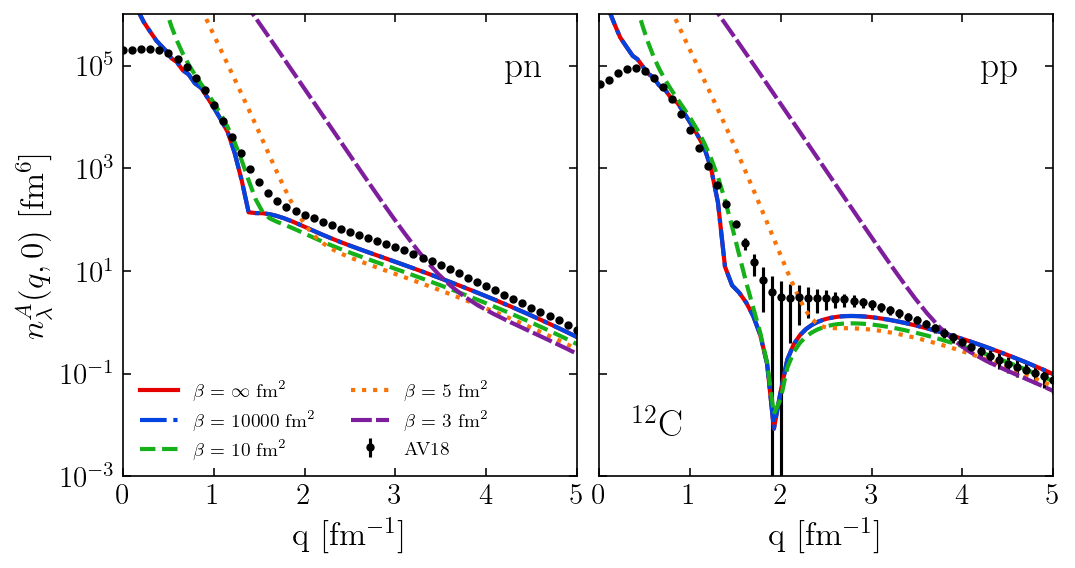

In [18]:
# Plot pair momentum distributions for several \beta
# Compare to AV18 QMC C12 Q = 0 results

# Get AV18 QMC data
file_name = 'AV18_C12_pmd_q_Q0p0.txt'
av18_data = np.loadtxt('data/qmc/' + file_name)
q_array_NN_av18 = av18_data[:, 0] # fm^-1

# Figure size
row_number = 1
col_number = 2
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n_{\lambda}^A(q,0)$' + ' [fm' + r'$^6$' + ']'
y_label_size = 16

# Axes limits
xlim = (0, 5)
ylim = (1e-3, 1e6)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

for i, pair in enumerate(['pn', 'pp']):
    
    # Set y-axis to log scale
    axs[i].set_yscale('log')
    
    # Set pair label
    pair_label_location = 'upper right'
    pair_label_size = 18
    anchored_text = AnchoredText(pair, loc=pair_label_location, prop=dict(size=pair_label_size), frameon=False)
    axs[i].add_artist(anchored_text)
 
    # Loop over \beta
    for j, beta in enumerate(beta_array):
        
        # Curve color
        curve_color = ff.xkcd_colors(j+1)
        curve_style = ff.line_styles(j)
    
        # Get momentum distributions
        n_array = d[pair][beta]
        if beta == 0.0:
            curve_label = r'$\beta=\infty$' + ' fm' + r'$^2$'
        else:
            curve_label = r'$\beta=%s$' % ff.convert_number_to_string(beta) + ' fm' + r'$^2$'
                
        # Add curve to figure
        axs[i].plot(q_array, n_array, label=curve_label, linewidth=curve_width, linestyle=curve_style,
                    color=curve_color)
        
#         # Print normalization: 4\pi/(2\pi)^3 \int dq q^2 n(q, 0)
#         if beta == 0.0:
#             print( 'beta = inf', 4*np.pi/(2*np.pi)**3 * np.sum(q_weights * q_array**2 * n_array) )
#         else:
#             print( 'beta = %s' % ff.convert_number_to_string(beta),
#                    4*np.pi/(2*np.pi)**3 * np.sum(q_weights * q_array**2 * n_array) )
    
    if pair == 'pn':
        n_array_av18 = av18_data[:, 1]
        error_bars_array_av18 = av18_data[:, 2]
    else:
        n_array_av18 = av18_data[:, 3]
        error_bars_array_av18 = av18_data[:, 4]
                    
    # AV18 data with error bars
    axs[i].errorbar(q_array_NN_av18, n_array_av18, yerr=error_bars_array_av18, color='xkcd:black', label='AV18',
                    linestyle='', marker='.')
                
    # Specify axes limits
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
        
    # Set axes labels
    axs[i].set_xlabel(x_label, fontsize=x_label_size)
    if i == 0:
        axs[i].set_ylabel(y_label, fontsize=y_label_size)
    
# Amount of white space in-between sub-plots
f.subplots_adjust(wspace=0.05)

# Add legend
legend_size = 9
legend_location = 'lower left'
axs[0].legend(ncol=2, loc=legend_location, fontsize=legend_size, frameon=False)
           
# Add nucleus label
nucleus_label = ff.nuclei_label_conversion('C12')
nucleus_label_location = 'lower left'
nucleus_label_size = 18
anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                             frameon=False)
axs[1].add_artist(anchored_text)
           
# Set file name
file_name = 'fermi_func_pmd_C12_channels'
# Add each channel to file name
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lambda_%s_kmax_%.1f_%s' % (6, ff.convert_number_to_string(lamb), kmax, edf)
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

_Takeaway points from smooth cutoff results_

1. We reproduce the results with $\theta$ by taking $\beta$ very large (e.g., $10000$ fm$^2$).
2. Still have a sharp cutoff near $k_F$ for $\beta$ values that give a reasonable normalization.
3. For low $\beta$ values, the distributions smooth out but way too much and at the cost of low momentum part being inaccurate.
4. Undershoots the tail of the distribution as $\beta$ decreases.
5. Changing the dependence in the exponent from $k_F-q$ to $k_F^2-q^2$ bends the curves more near $k_F$.

__References__

[1] T. Neff, H. Feldmeier, and W. Horiuchi, Phys. Rev. C __92__, 024003 (2015), arXiv:1506.02237 [nucl-th].<br/>
[2] E. D. Jurgenson, P. Navratil, and R. J. Furnstahl, Phys. Rev. Lett. __103__, 082501 (2009), arXiv:0905.1873 [nucl-th].<br/>
[3] S. K. Bogner, R. J. Furnstahl, and R. J. Perry, Ann. Phys. (Leipzig) __323__, 1478 (2008), 	arXiv:0708.1602 [nucl-th].